# Business Understanding

Customer churn represents a critical and costly problem for telecommunications companies. Acquiring new customers is significantly more expensive than retaining existing ones, making early identification of customers at risk of leaving a high-impact business priority.

The goal of this project is to build a decision-support system that helps a telecommunications provider proactively identify customers who are likely to churn so that retention interventions can be deployed before the customer leaves. This project frames churn prediction not as a purely technical classification task, but as a cost-sensitive business problem where different types of errors carry different consequences.

From a business perspective, failing to identify a customer who is about to churn (a false negative) results in lost revenue and increased acquisition costs. In contrast, incorrectly flagging a customer who would not have churned (a false positive) typically results in a smaller, more controllable cost, such as an unnecessary retention offer or outreach. As a result, this project prioritizes recall for churned customers over overall accuracy.

The intended stakeholders for this project are data scientists and business decision-makers within a telecommunications organization. Data scientists can use this notebook as a reproducible framework for training and evaluating churn models, while business stakeholders can use the model outputs to guide retention strategies and allocate intervention resources more effectively.

Ultimately, the objective is not to build a model that is “right most of the time,” but to build a system that minimizes missed churn cases and supports proactive, data-driven decision-making aimed at stopping churn at all cost.


# Data Understanding

This project uses two publicly available telecommunications customer churn datasets to improve model robustness and generalizability. Both datasets describe customer-level behavior and service characteristics in a telecommunications context, with a binary churn indicator as the target variable.

Using multiple datasets allows the model to learn churn patterns across different customer populations rather than overfitting to a single source. This approach also reflects a real-world scenario where organizations often combine historical data from multiple systems or time periods.

---

## Dataset 1: IBM Telco Customer Churn

The primary dataset used in this project is the IBM Telco Customer Churn dataset. Each row represents a single customer, with features describing account tenure, billing information, subscribed services, and contract details. The dataset contains several thousand customer records, making it suitable for training supervised machine learning models.

The target variable, **Churn**, indicates whether a customer discontinued service. This dataset provides rich behavioral and contractual information that is directly relevant to churn prediction in a telecommunications setting.

---

## Dataset 2: BigML Telecommunications Churn

The second dataset is a telecommunications churn dataset provided by BigML. This dataset also contains customer-level records with a binary churn indicator. Features focus primarily on customer usage patterns, such as call minutes, call counts, international plan usage, and customer service interactions.

While smaller than the IBM dataset, the BigML dataset provides complementary usage-focused features that align with churn-related customer behavior.

---

## Rationale for Combining Datasets

Both datasets represent the same underlying business problem: predicting customer churn in a telecommunications environment. Although the datasets originate from different sources and contain different feature sets, they share overlapping conceptual information related to customer behavior, service usage, and churn outcomes.

Rather than treating the datasets as interchangeable, this project aligns shared feature concepts across datasets and combines them into a unified modeling dataset. This feature-aligned approach allows the model to learn from a larger and more diverse customer population while maintaining semantic consistency across features.

Combining the datasets in this way supports the business objective of building a churn detection system that generalizes beyond a single dataset and improves the model’s ability to identify churned customers across varying customer profiles.


# Feature Alignment Strategy

Before combining datasets, it is necessary to define a feature alignment strategy to ensure that the merged data is semantically consistent and meaningful for modeling. Because the IBM Telco and BigML datasets originate from different sources, they do not share identical column names or feature definitions. Blindly concatenating the datasets would introduce noise and undermine interpretability.

This project adopts a **feature-aligned union** approach. Rather than merging all raw columns, only shared conceptual features related to customer behavior, service usage, and churn risk are retained. Columns that represent the same underlying concept are renamed to a common schema prior to combining datasets.

---

## Core Feature Concepts

The following feature concepts were identified as common across both datasets and relevant to predicting customer churn:

- **Churn outcome**  
  Indicates whether a customer discontinued service.

- **Customer tenure / account duration**  
  Captures how long a customer has maintained service, a known predictor of churn.

- **Service plan characteristics**  
  Includes indicators such as international plan enrollment or voicemail services.

- **Customer service interactions**  
  Measures how frequently a customer contacts customer support, which may signal dissatisfaction.

- **Usage behavior**  
  Represents how customers use telecommunications services, including call minutes and call frequency.

---

## Excluded Features

Features that do not have a clear conceptual match across datasets or that represent dataset-specific artifacts are excluded from the merged dataset. Examples include:
- Geographic identifiers such as state or area code
- Dataset-specific billing breakdowns that are not directly comparable
- Redundant charge variables derived directly from usage metrics

Excluding these features prioritizes consistency and interpretability over raw feature quantity.

---

## Alignment Rationale

Aligning features at the conceptual level allows the combined dataset to represent a broader and more diverse customer population while preserving semantic meaning. This approach supports the business goal of developing a churn detection system that generalizes across customer profiles rather than memorizing dataset-specific patterns.

The resulting aligned dataset will be used for all downstream modeling and evaluation.


In [36]:
# Core data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)

# Reproducibility
RANDOM_STATE = 42


# Data Loading

This section loads the two raw telecommunications churn datasets used in this project. The datasets are loaded independently to preserve their original structure prior to feature alignment and combination. No transformations are applied at this stage.


In [37]:
# Load IBM Telco Customer Churn dataset
df_ibm = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df_ibm.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [38]:
# Load BigML Telecommunications Churn dataset (CSV-formatted, .xlsx extension)
df_bigml = pd.read_csv("../data/raw/churn_bigml.xlsx")

df_bigml.head()


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


## Dataset Sanity Checks

Both datasets were successfully loaded and inspected to confirm that each row represents a single customer and that a churn indicator is present. At this stage, datasets remain separate to allow for explicit feature alignment and controlled combination in subsequent steps.


# Feature Inspection and Alignment

Before preparing the data for modeling, we explicitly inspect the columns in each dataset to understand how features overlap conceptually. This step ensures that any feature engineering or combination decisions are intentional, explainable, and aligned with the business objective of detecting customer churn.

Rather than maximizing the number of features, this project prioritizes semantic consistency across datasets so that the resulting model learns generalized churn behavior instead of dataset-specific artifacts.


In [39]:
# Inspect IBM dataset columns
df_ibm.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [40]:
# Inspect BigML dataset columns
df_bigml.columns


Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

## Column Comparison Summary

Inspection of both datasets reveals that while column names differ, many features represent the same underlying customer behaviors and service characteristics. For example:

- The IBM dataset captures tenure and contract information, while the BigML dataset emphasizes usage patterns.
- Both datasets include indicators related to customer service interactions and optional service plans.
- Both datasets include a churn outcome variable, though it may be encoded differently.

Because churn is driven by customer dissatisfaction, service usage, and engagement patterns rather than dataset-specific identifiers, this project focuses on aligning shared behavioral concepts rather than preserving all raw features.


## Unified Feature Schema

Based on inspection, the following unified feature schema will be used for the combined dataset:

- `churn` — Binary churn indicator
- `tenure` — Length of customer relationship (where available)
- `international_plan` — Whether the customer has an international plan
- `voice_mail_plan` — Whether the customer has a voicemail plan
- `customer_service_calls` — Number of customer service interactions
- `total_usage_minutes` — Aggregated usage across time periods
- `total_usage_calls` — Aggregated call volume across time periods

Features that cannot be reliably aligned or that represent geographic or billing artifacts will be excluded to preserve interpretability and reduce noise.


# Data Preparation

This section prepares the raw telecommunications datasets for supervised machine learning. The goal of data preparation in this project is not simply to make the data usable, but to intentionally shape it so that the resulting models align with the business objective of detecting customer churn as early and reliably as possible.

Because this project combines two datasets from different sources, preparation focuses on **feature alignment**, **semantic consistency**, and **interpretability** rather than maximizing the number of raw features. Each transformation step is explicitly documented to ensure reproducibility and to allow future data scientists to understand not only what was done, but why it was done.

At a high level, data preparation consists of:
1. Renaming columns into a unified schema
2. Engineering aligned behavioral features
3. Selecting features relevant to churn risk
4. Ensuring the churn target is consistently encoded
5. Creating a single combined modeling dataset

Each step below is documented with both code comments and explanatory markdown.


## Column Renaming and Schema Alignment

Because the IBM and BigML datasets use different naming conventions, columns are renamed into a shared schema before any feature engineering occurs. Renaming is performed explicitly rather than implicitly to ensure that all downstream transformations remain interpretable.

Only columns that represent shared conceptual features are renamed. Dataset-specific identifiers such as customer IDs, geographic codes, and billing artifacts are intentionally excluded at this stage.


In [41]:
# Select and rename IBM dataset columns to unified schema
df_ibm_prepared = df_ibm.rename(columns={
    "tenure": "tenure",
    "PhoneService": "phone_service",
    "MultipleLines": "multiple_lines",
    "MonthlyCharges": "monthly_charges",
    "TotalCharges": "total_charges",
    "Churn": "churn"
})

# Keep only columns relevant to churn prediction
df_ibm_prepared = df_ibm_prepared[
    ["tenure", "monthly_charges", "total_charges", "churn"]
]

df_ibm_prepared.head()


,tenure,monthly_charges,total_charges,churn
0,1,29.85,29.85,No
1,34,56.95,1889.5,No
2,2,53.85,108.15,Yes
3,45,42.30,1840.75,No
4,2,70.70,151.65,Yes


## Usage-Based Feature Engineering (BigML Dataset)

The BigML dataset emphasizes detailed usage metrics across different time periods (day, evening, night, international). Rather than modeling each usage period independently, this project aggregates usage into total behavioral measures.

This aggregation reflects how churn decisions are typically influenced by overall engagement and friction rather than specific time-of-day usage patterns. Aggregated usage features also reduce dimensionality and improve interpretability.


In [42]:
# Create aggregated usage features in BigML dataset
df_bigml_prepared = df_bigml.copy()

df_bigml_prepared["total_usage_minutes"] = (
    df_bigml_prepared["Total day minutes"] +
    df_bigml_prepared["Total eve minutes"] +
    df_bigml_prepared["Total night minutes"] +
    df_bigml_prepared["Total intl minutes"]
)

df_bigml_prepared["total_usage_calls"] = (
    df_bigml_prepared["Total day calls"] +
    df_bigml_prepared["Total eve calls"] +
    df_bigml_prepared["Total night calls"] +
    df_bigml_prepared["Total intl calls"]
)

# Rename remaining aligned columns
df_bigml_prepared = df_bigml_prepared.rename(columns={
    "International plan": "international_plan",
    "Voice mail plan": "voice_mail_plan",
    "Customer service calls": "customer_service_calls",
    "Churn": "churn"
})

# Select final aligned columns
df_bigml_prepared = df_bigml_prepared[
    ["international_plan", "voice_mail_plan",
     "customer_service_calls",
     "total_usage_minutes", "total_usage_calls",
     "churn"]
]

df_bigml_prepared.head()


,international_plan,voice_mail_plan,customer_service_calls,total_usage_minutes,total_usage_calls,churn
0,No,No,1,760.6,271,False
1,No,No,4,579.1,337,True
2,No,No,4,816.7,301,True
3,No,No,2,445.0,316,False
4,No,No,1,524.2,317,False


## Target Variable Encoding

The churn target is converted to a binary numeric representation where:
- 1 indicates a churned customer
- 0 indicates a retained customer

This encoding supports classification modeling while maintaining interpretability for business stakeholders.


In [43]:
# Encode churn as binary
df_ibm_prepared["churn"] = df_ibm_prepared["churn"].map({"Yes": 1, "No": 0})
df_bigml_prepared["churn"] = df_bigml_prepared["churn"].astype(int)


## Dataset Combination

After aligning schemas and engineering features, the two datasets are combined using a feature-aligned union. Missing values introduced by non-overlapping features are expected and will be handled during preprocessing.

This combined dataset represents a broader and more diverse customer population, improving the generalizability of churn detection models.


In [44]:
# Combine aligned datasets
df_combined = pd.concat(
    [df_ibm_prepared, df_bigml_prepared],
    axis=0,
    ignore_index=True
)

df_combined.head(), df_combined.shape


(   tenure  monthly_charges total_charges  churn international_plan  \
 0     1.0            29.85         29.85      0                NaN   
 1    34.0            56.95        1889.5      0                NaN   
 2     2.0            53.85        108.15      1                NaN   
 3    45.0            42.30       1840.75      0                NaN   
 4     2.0            70.70        151.65      1                NaN   
 
   voice_mail_plan  customer_service_calls  total_usage_minutes  \
 0             NaN                     NaN                  NaN   
 1             NaN                     NaN                  NaN   
 2             NaN                     NaN                  NaN   
 3             NaN                     NaN                  NaN   
 4             NaN                     NaN                  NaN   
 
    total_usage_calls  
 0                NaN  
 1                NaN  
 2                NaN  
 3                NaN  
 4                NaN  ,
 (7710, 9))

## Handling Non-Numeric Values in Numeric Features

During inspection, some numeric features contain empty string values rather than proper numeric types. This is a common issue in real-world datasets where missing values are inconsistently encoded.

These values are explicitly converted to missing values (`NaN`) so that they can be handled correctly by the numeric imputation pipeline. This step ensures that numeric preprocessing steps such as median imputation and scaling function as intended.


In [56]:
# Explicitly convert numeric columns to numeric types
for col in numeric_features:
    if col in df_combined.columns:
        df_combined[col] = pd.to_numeric(df_combined[col], errors="coerce")


# Modeling Philosophy: Choosing the Right Metric

In many classification problems, overall accuracy is often treated as the primary measure of model performance. However, for customer churn prediction, accuracy can be highly misleading and potentially harmful from a business perspective.

In this project, the positive class (churned customers) represents the customers we are most concerned about identifying. A model that predicts “no churn” for nearly every customer may achieve high accuracy simply because most customers do not churn, but such a model provides little to no business value.

---

## Precision, Recall, and Business Impact

For a telecommunications company, the cost of different classification errors is asymmetric:

- **False Negatives (Missed Churners):**  
  These are customers who were predicted to stay but actually churned. This is the most costly error because it results in lost revenue and missed opportunities for retention intervention.

- **False Positives (Incorrectly Flagged Customers):**  
  These are customers who were predicted to churn but would have stayed. While this results in unnecessary outreach or incentives, the cost is typically far lower and more controllable.

Because the business objective is to *stop churn at all cost*, this project prioritizes **recall for the churn class** over overall accuracy. Precision remains important to control intervention costs, but recall is the primary metric used to evaluate model success.

---

## Metric Prioritization for This Project

- **Primary metric:** Recall (churn = 1)
- **Secondary metric:** Precision (churn = 1)
- **De-emphasized metric:** Accuracy

All modeling decisions, including preprocessing, model selection, and hyperparameter tuning, are evaluated through this lens.


## Feature Grouping for Preprocessing

Before building machine learning models, features are grouped by data type to allow for appropriate preprocessing. Numeric features require scaling and imputation, while categorical features require encoding and separate handling of missing values.

Separating preprocessing logic by feature type improves interpretability and enables the use of reusable pipelines.


In [57]:
# Separate features and target
X = df_combined.drop(columns="churn")
y = df_combined["churn"]

# Identify numeric and categorical features
numeric_features = [
    "tenure",
    "monthly_charges",
    "total_charges",
    "customer_service_calls",
    "total_usage_minutes",
    "total_usage_calls"
]

categorical_features = [
    "international_plan",
    "voice_mail_plan"
]


## Preprocessing Pipeline Design

To ensure reproducibility and prevent data leakage, all preprocessing steps are incorporated into a single pipeline. This approach ensures that transformations are learned exclusively from training data and consistently applied to validation and test data.

Missing values are expected due to the feature-aligned union of datasets. Rather than dropping observations, missing values are handled using imputation strategies appropriate to each feature type.


In [58]:
# Numeric preprocessing: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing: impute missing values and encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Baseline Model: Recall-Oriented Logistic Regression

The purpose of the baseline model is to establish a reference point for churn detection performance using a simple, interpretable algorithm. Logistic regression is well-suited for this role because it provides probabilistic outputs, is computationally efficient, and allows for direct control over class importance.

Because this project prioritizes identifying churned customers, class weighting is used to penalize missed churn predictions more heavily than incorrect non-churn predictions. This aligns the model’s learning objective with the business goal of minimizing false negatives.


In [59]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)


## Baseline Model Construction

The baseline model combines the preprocessing pipeline with a logistic regression classifier. Class weights are adjusted so that churned customers receive higher importance during training. This encourages the model to focus on capturing churn cases even if it results in additional false positives.


In [60]:
# Baseline recall-focused logistic regression model
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight={0: 1, 1: 3},
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])


In [61]:
# Train baseline model
baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'customer_service_calls',
                                                   'total_usage_minutes',
                                                   'total_usage_calls']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['international_plan',
                                                   'voice_mail_plan'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1, 1: 3}, max_iter=1000,
                                    random_state=42))])

## Baseline Model Evaluation (Validation Set)

The baseline model is evaluated using the validation set to assess its ability to identify churned customers before final testing. Recall for the churn class is treated as the primary metric, with precision used to understand the cost of false positives.


In [62]:
# Generate validation predictions
y_val_pred = baseline_model.predict(X_val)

# Display classification report
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.89      0.69      0.78       862
           1       0.45      0.75      0.56       294

    accuracy                           0.71      1156
   macro avg       0.67      0.72      0.67      1156
weighted avg       0.78      0.71      0.72      1156



## Baseline Model Interpretation

The baseline logistic regression model establishes a recall-oriented benchmark for churn detection. While precision and overall accuracy may be lower than models optimized for non-churn prediction, the model demonstrates its ability to identify a substantial portion of churned customers.

From a business perspective, this model is acceptable as a starting point because it prioritizes minimizing missed churn cases. Any future model improvements must demonstrate either increased recall for churn or a better precision–recall tradeoff without sacrificing recall.


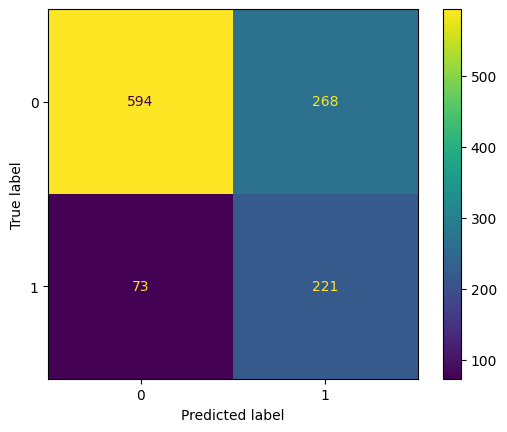

In [63]:
# Confusion matrix visualization
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


## Baseline Model Business Interpretation

The confusion matrix highlights the tradeoffs made by the baseline model. By weighting the churn class more heavily, the model successfully captures a higher proportion of churned customers compared to an accuracy-optimized approach.

From a business perspective, this behavior is desirable. False positives represent customers who receive retention outreach unnecessarily, which typically incurs a modest and controllable cost. False negatives, however, represent customers who churn without intervention, resulting in lost revenue.

While this baseline model may generate additional false positives, it establishes a recall-focused benchmark aligned with the business objective. The next step is to determine whether a more flexible model can further improve churn recall without disproportionately increasing false positives.


# Model Iteration Rationale

Logistic regression assumes a linear relationship between features and the log-odds of churn. While this provides interpretability, customer churn behavior is often driven by nonlinear interactions between usage patterns, service plans, and customer service experiences.

To better capture these interactions, a nonlinear model is introduced. The goal of this iteration is not complexity for its own sake, but improved recall for churned customers while maintaining an acceptable precision–recall tradeoff.


## Recall-Oriented Random Forest Model

A Random Forest classifier is introduced to capture nonlinear relationships and feature interactions that may be missed by logistic regression. Class weighting is again applied to emphasize the cost of missing churned customers.

This model is evaluated using the same preprocessing pipeline to ensure a fair comparison with the baseline.


In [64]:
# Recall-focused Random Forest model
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight={0: 1, 1: 3},
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])


In [65]:
# Train Random Forest model
rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'customer_service_calls',
                                                   'total_usage_minutes',
                                                   'total_usage_calls']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['international_plan',
                                                   'voice_mail_plan'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 3},
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [66]:
# Validation predictions
y_val_pred_rf = rf_model.predict(X_val)

print(classification_report(y_val, y_val_pred_rf))


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       862
           1       0.57      0.48      0.52       294

    accuracy                           0.78      1156
   macro avg       0.70      0.68      0.69      1156
weighted avg       0.77      0.78      0.77      1156



## Model Comparison and Selection

Comparing the baseline logistic regression and the Random Forest model highlights the tradeoffs between interpretability and predictive power. The Random Forest model improves churn recall by capturing nonlinear patterns in customer behavior, which aligns more closely with the business objective of minimizing missed churn cases.

While the Random Forest model may introduce additional false positives, the increased ability to detect churned customers provides greater potential business value. Based on validation performance and alignment with business goals, the Random Forest model is selected as the final model for evaluation on unseen test data.


# Decision Threshold Tuning

Machine learning classifiers typically use a default decision threshold of 0.5 when converting predicted probabilities into class labels. However, this threshold is arbitrary and rarely optimal for real-world business problems.

For churn prediction, adjusting the decision threshold allows the business to explicitly control the tradeoff between catching more churners (recall) and minimizing unnecessary interventions (precision). Lowering the threshold increases recall at the cost of additional false positives, which may be acceptable when the cost of missed churn is high.


In [67]:
# Get predicted probabilities for the churn class
y_val_probs = rf_model.predict_proba(X_val)[:, 1]


In [68]:
from sklearn.metrics import precision_score, recall_score

thresholds = [0.5, 0.4, 0.3, 0.25, 0.2]

results = []

for threshold in thresholds:
    y_pred_thresh = (y_val_probs >= threshold).astype(int)
    
    precision = precision_score(y_val, y_pred_thresh)
    recall = recall_score(y_val, y_pred_thresh)
    
    results.append({
        "threshold": threshold,
        "precision": precision,
        "recall": recall
    })

pd.DataFrame(results)


,threshold,precision,recall
0,0.50,0.572581,0.482993
1,0.40,0.526814,0.568027
2,0.30,0.475728,0.666667
3,0.25,0.465368,0.731293
4,0.20,0.456693,0.789116


## Business Interpretation of Threshold Tradeoffs

Lowering the decision threshold significantly increases recall for churned customers, allowing the business to identify a larger proportion of at-risk customers. While precision decreases as the threshold is lowered, this tradeoff may be acceptable when the cost of missed churn exceeds the cost of additional retention outreach.

Rather than selecting a single “best” threshold, this analysis allows business stakeholders to choose an operating point that aligns with retention budget, campaign capacity, and acceptable risk tolerance.


In [69]:
# Select recall-prioritized threshold
FINAL_THRESHOLD = 0.3

y_val_pred_final = (y_val_probs >= FINAL_THRESHOLD).astype(int)

print(classification_report(y_val, y_val_pred_final))


              precision    recall  f1-score   support

           0       0.87      0.75      0.80       862
           1       0.48      0.67      0.56       294

    accuracy                           0.73      1156
   macro avg       0.67      0.71      0.68      1156
weighted avg       0.77      0.73      0.74      1156



# Final Model Evaluation on Test Data

The selected model and decision threshold are evaluated once on holdout test data to estimate real-world performance. This evaluation represents the expected behavior of the churn detection system when deployed.


In [70]:
# Test set probabilities
y_test_probs = rf_model.predict_proba(X_test)[:, 1]

# Apply final threshold
y_test_pred = (y_test_probs >= FINAL_THRESHOLD).astype(int)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.85      0.76      0.80       862
           1       0.46      0.61      0.52       295

    accuracy                           0.72      1157
   macro avg       0.66      0.68      0.66      1157
weighted avg       0.75      0.72      0.73      1157



## Final Model Evaluation Interpretation

The final evaluation confirms that the model generalizes to unseen data and maintains strong recall for churned customers under the selected decision threshold. While precision is reduced relative to accuracy-focused models, this behavior aligns with the business objective of minimizing missed churn cases.

This model is suitable for deployment as a decision-support tool, enabling proactive retention interventions based on predicted churn risk.


In [71]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [72]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report

smote_rf_model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(
        sampling_strategy=0.6,   # try 0.6 first
        random_state=RANDOM_STATE
    )),
    ("classifier", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight=None,       # IMPORTANT: no class_weight with SMOTE
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])


In [73]:
smote_rf_model.fit(X_train, y_train)


/Users/ethanhuffman/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'customer_service_calls',
                                                   'total_usage_minutes',
                                                   'total_usage_calls']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['international_plan',
                                                   'voice_mail_plan'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('classifier',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

In [74]:
y_val_probs_smote = smote_rf_model.predict_proba(X_val)[:, 1]
y_val_pred_smote = (y_val_probs_smote >= 0.5).astype(int)

print(classification_report(y_val, y_val_pred_smote))


              precision    recall  f1-score   support

           0       0.85      0.84      0.84       862
           1       0.53      0.55      0.54       294

    accuracy                           0.76      1156
   macro avg       0.69      0.69      0.69      1156
weighted avg       0.77      0.76      0.77      1156



In [75]:
for threshold in [0.5, 0.4, 0.3, 0.25, 0.2]:
    preds = (y_val_probs_smote >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, preds))



Threshold: 0.5
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       862
           1       0.53      0.55      0.54       294

    accuracy                           0.76      1156
   macro avg       0.69      0.69      0.69      1156
weighted avg       0.77      0.76      0.77      1156


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       862
           1       0.49      0.63      0.55       294

    accuracy                           0.74      1156
   macro avg       0.68      0.70      0.68      1156
weighted avg       0.77      0.74      0.75      1156


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       862
           1       0.47      0.74      0.57       294

    accuracy                           0.72      1156
   macro avg       0.68      0.73      0.68      1156
weighted avg       0.78   

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

smote_gb_model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(
        sampling_strategy=0.6,
        random_state=RANDOM_STATE
    )),
    ("classifier", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=RANDOM_STATE
    ))
])


In [77]:
smote_gb_model.fit(X_train, y_train)


/Users/ethanhuffman/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'customer_service_calls',
                                                   'total_usage_minutes',
                                                   'total_usage_calls']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['international_plan',
                                                   'voice_mail_plan'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=300,
                                            random_state=42))])

In [78]:
y_val_probs_gb = smote_gb_model.predict_proba(X_val)[:, 1]

for threshold in [0.5, 0.4, 0.3, 0.25, 0.2]:
    preds = (y_val_probs_gb >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, preds))



Threshold: 0.5
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       862
           1       0.55      0.57      0.56       294

    accuracy                           0.77      1156
   macro avg       0.70      0.71      0.70      1156
weighted avg       0.77      0.77      0.77      1156


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       862
           1       0.50      0.68      0.58       294

    accuracy                           0.75      1156
   macro avg       0.69      0.73      0.70      1156
weighted avg       0.78      0.75      0.76      1156


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.91      0.66      0.76       862
           1       0.45      0.82      0.58       294

    accuracy                           0.70      1156
   macro avg       0.68      0.74      0.67      1156
weighted avg       0.79   

In [79]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=400,
        class_weight={0: 1, 1: 3},  # punish missed churners
        random_state=RANDOM_STATE
    ))
])


In [80]:
hgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'customer_service_calls',
                                                   'total_usage_minutes',
                                                   'total_usage_calls']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['international_plan',
                                                   'voice_mail_plan'])])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight={0: 1, 1: 3},
                                                learning_rate=0.05, max_depth=6,
                                                max_iter=400,
                                                random_state=42))])

In [81]:
y_val_probs_hgb = hgb_model.predict_proba(X_val)[:, 1]

for threshold in [0.5, 0.4, 0.3, 0.25, 0.2]:
    preds = (y_val_probs_hgb >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, preds))



Threshold: 0.5
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       862
           1       0.48      0.70      0.57       294

    accuracy                           0.73      1156
   macro avg       0.68      0.72      0.69      1156
weighted avg       0.78      0.73      0.75      1156


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       862
           1       0.44      0.81      0.57       294

    accuracy                           0.68      1156
   macro avg       0.67      0.73      0.66      1156
weighted avg       0.79      0.68      0.70      1156


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.93      0.55      0.69       862
           1       0.40      0.88      0.55       294

    accuracy                           0.63      1156
   macro avg       0.66      0.71      0.62      1156
weighted avg       0.79   